In [1]:
import pandas as pd
import math
import numpy as np
from sklearn.metrics import classification_report
import torch.nn.functional as F
import torch
import os
from tqdm import tqdm,trange
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer)
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('../data/classification_dataset.csv')

In [44]:
df

,text,l1,l2,l3
0,"Ronald \""Ron\"" D. Boire is an American busines...",Agent,Person,BusinessPerson
1,Astra 1KR is one of the Astra geostationary sa...,Place,Satellite,ArtificialSatellite
2,Cycleryon is an extinct genus of decapod crust...,Species,Animal,Crustacean
3,"Angela Maria of the Heart of Jesus, also calle...",Agent,Cleric,Saint
4,"William Garnet \""Bing\"" Coughlin – Canadian Wo...",Agent,Artist,ComicsCreator
...,...,...,...,...
342776,The Messenger is a quarterly magazine publishe...,Work,PeriodicalLiterature,Magazine
342777,"Seren \""Haf\"" Gibson (born in Ruthin, Denbighs...",Agent,Actor,AdultActor
342778,Anne Margrethe Strømsheim (née Bang) (1914 – 6...,Agent,Person,MilitaryPerson
342779,116 Sirona is a somewhat large and bright-colo...,Place,CelestialBody,Planet


In [24]:
df.l1.value_counts()

Agent             177341
Place              65128
Species            31149
Work               29832
Event              27059
SportsSeason        8307
UnitOfWork          2497
TopicalConcept      1115
Device               353
Name: l1, dtype: int64

<AxesSubplot:>

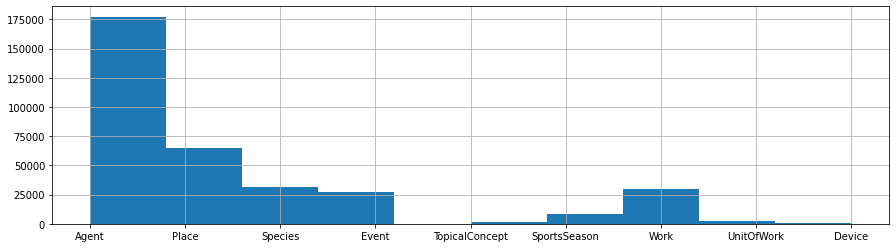

In [8]:
df.l1.hist(figsize=(15,4))

<AxesSubplot:>

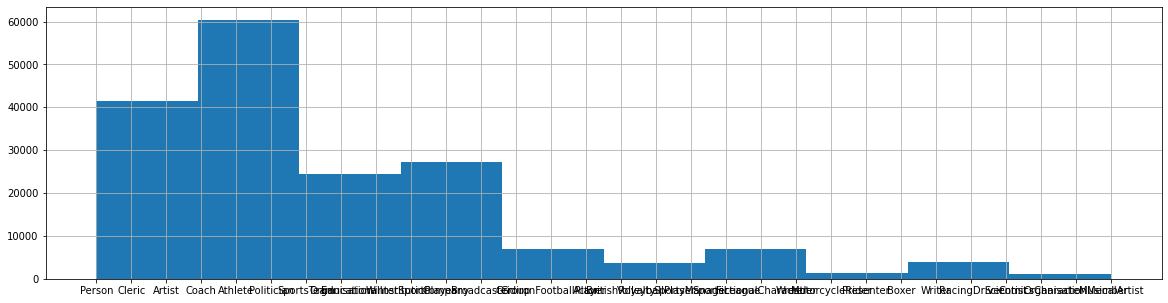

In [47]:
df[df['l1'] == 'Agent'].l2.hist(figsize=(20,5))

In [48]:
df[df['l1'] == 'Agent'].l2.value_counts()

Athlete                   44163
Person                    27892
Politician                13514
Company                   11777
Organisation              10137
WinterSportPlayer          8972
SportsTeam                 7968
Artist                     7091
Broadcaster                6549
Cleric                     6420
EducationalInstitution     6306
SportsLeague               3405
FictionalCharacter         3062
GridironFootballPlayer     2696
SportsManager              2695
Coach                      2691
Group                      2659
Actor                      1667
RacingDriver               1593
Writer                     1562
Scientist                   824
BritishRoyalty              685
MotorcycleRider             633
OrganisationMember          553
Wrestler                    425
Boxer                       403
Presenter                   318
MusicalArtist               284
ComicsCharacter             203
VolleyballPlayer            194
Name: l2, dtype: int64

In [94]:
df[df['l2'] == 'Person'].l3.value_counts()

Noble              2693
MilitaryPerson     2665
OfficeHolder       2641
Judge              2606
Architect          2579
Monarch            2293
BeautyQueen        2194
Philosopher        1703
Model              1543
Journalist         1468
Economist          1052
Religious           909
BusinessPerson      716
Engineer            707
Ambassador          572
Astronaut           569
Chef                522
PlayboyPlaymate     243
HorseTrainer        217
Name: l3, dtype: int64

In [55]:
len(df[df['l2'] == 'Person'].l3.unique()) == 1

19

In [80]:
for l1_label in df.l1.unique():
    if len(df[df['l1'] == l1_label].l3.unique()) == 1:
        l2_label = df[df['l1'] == l1_label].l2.unique()
        l3_label = df[df['l1'] == l1_label].l3.unique()
        print(f'{l1_label} - {l2_label} - {l3_label}')


TopicalConcept - ['Genre'] - ['MusicGenre']
UnitOfWork - ['LegalCase'] - ['SupremeCourtOfTheUnitedStatesCase']
Device - ['Engine'] - ['AutomobileEngine']


In [104]:
counts = list()

for label in df.l2.unique():
    size = len(df[df['l2'] == label].l3.unique())
    counts.append(size)
    l1_label = df[df['l2'] == label].l1.unique()
    if size > 8:
        print(f'{size}: {label}: {l1_label}')
    
print(sorted(counts))


19: Person: ['Agent']
27: Athlete: ['Agent']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 7, 8, 8, 8, 8, 19, 27]


In [105]:
counts = list()

for label in df.l1.unique():
    size = len(df[df['l1'] == label].l2.unique())
    counts.append(size)
    if size > 8:
        print(f'{size}: {label}')
    
print(sorted(counts))


30: Agent
16: Place
[1, 1, 1, 2, 5, 6, 8, 16, 30]


In [58]:
len(df.l2.unique())

70

In [59]:
df[df['l2'] == 'MusicalArtist']

,text,l1,l2,l3
2325,"Lívia Rév (born July 5, 1916) is a classical c...",Agent,MusicalArtist,ClassicalMusicArtist
2397,"Alessandro Taverna (born in Portogruaro, Venic...",Agent,MusicalArtist,ClassicalMusicArtist
4236,"Jasna Popovic (born May 10, 1979) is an award-...",Agent,MusicalArtist,ClassicalMusicArtist
6231,"Arthur Moreira Lima (born July 16, 1940 in Rio...",Agent,MusicalArtist,ClassicalMusicArtist
13083,"Tristan Pfaff (born 1985) is a French pianist,...",Agent,MusicalArtist,ClassicalMusicArtist
...,...,...,...,...
338471,"Konstanze Eickhorst (born 6 May 1961, in Breme...",Agent,MusicalArtist,ClassicalMusicArtist
338903,"Ferhunde Erkin (née Ferhunde Remzi) (June 8, 1...",Agent,MusicalArtist,ClassicalMusicArtist
339788,Míċeál O'Rourke is an Irish pianist who is bes...,Agent,MusicalArtist,ClassicalMusicArtist
340092,"Paul von Jankó (June 2, 1856 – March 17, 1919)...",Agent,MusicalArtist,ClassicalMusicArtist


<AxesSubplot:>

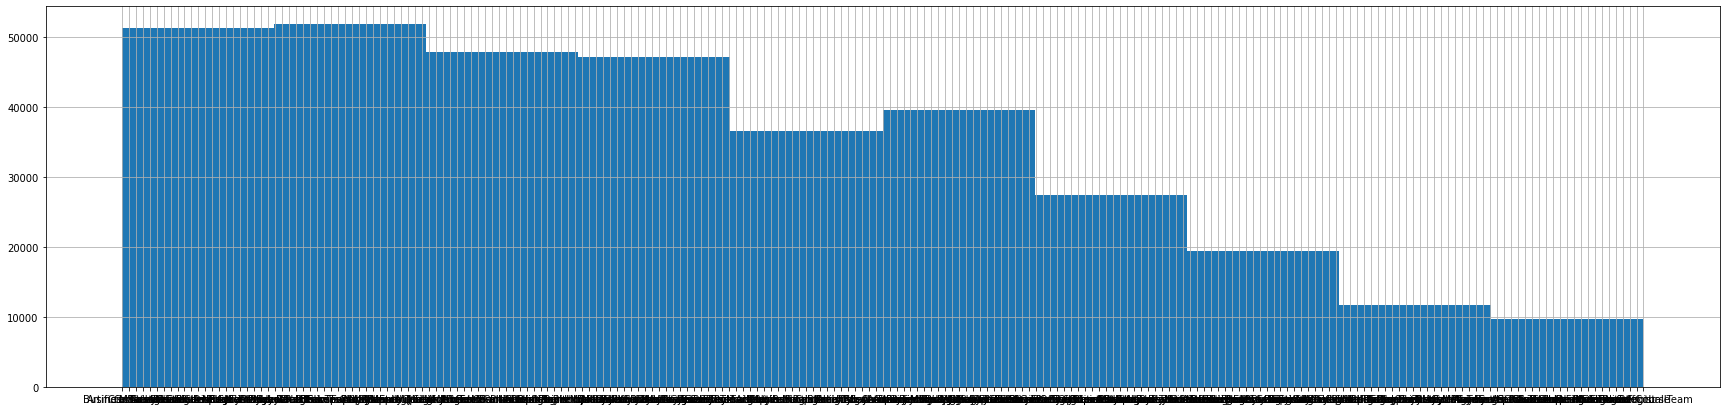

In [91]:
df.l3.hist(figsize=(30,7))

In [92]:
df.l3.value_counts()

AcademicJournal          2700
FootballMatch            2700
Planet                   2700
Manga                    2700
GolfPlayer               2700
                         ... 
Cycad                     204
AnimangaCharacter         203
BeachVolleyballPlayer     194
CanadianFootballTeam      190
BiologicalDatabase        187
Name: l3, Length: 219, dtype: int64

<AxesSubplot:>

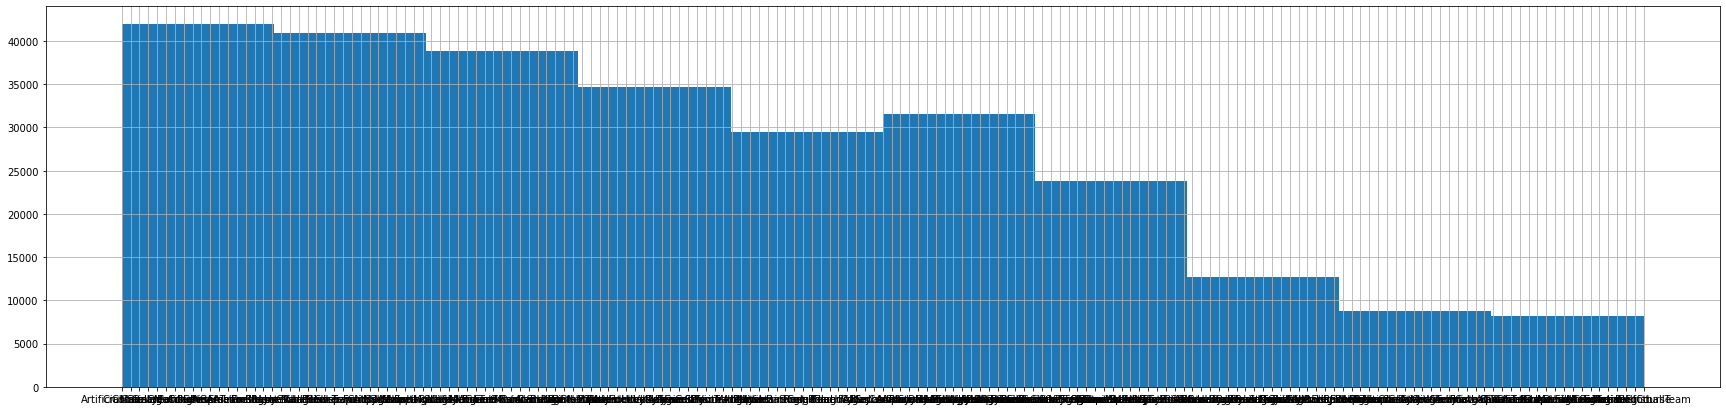

In [90]:
df[~df.l2.isin(['Athlete', 'Person'])].l3.hist(figsize=(30,7))

In [96]:
df[df.l1.isin(['Agent']) & ~df.l2.isin(['Athlete', 'Person'])].l3.value_counts()

FigureSkater              2698
Airline                   2697
Bank                      2696
AmericanFootballPlayer    2696
SoccerManager             2695
                          ... 
IceHockeyLeague            273
Brewery                    250
AnimangaCharacter          203
BeachVolleyballPlayer      194
CanadianFootballTeam       190
Name: l3, Length: 77, dtype: int64

In [99]:
df[df.l1.isin(['Place'])].l3.unique()

array(['ArtificialSatellite', 'Planet', 'Diocese', 'Castle', 'Village',
       'Lake', 'Town', 'Airport', 'Mountain', 'ShoppingMall',
       'RailwayLine', 'Museum', 'MountainPass', 'Bridge', 'Dam',
       'Lighthouse', 'Glacier', 'River', 'Volcano', 'MountainRange',
       'Hospital', 'Road', 'RailwayStation', 'Prison', 'Restaurant',
       'Stadium', 'HistoricBuilding', 'Theatre', 'Hotel', 'Racecourse',
       'RollerCoaster', 'Galaxy', 'CricketGround', 'Cave', 'Canal',
       'RoadTunnel', 'GolfCourse'], dtype=object)

In [106]:
# check for repeated data

len(df) == len(df.text.unique())

,text,l1,l2,l3
0,"Ronald \""Ron\"" D. Boire is an American busines...",Agent,Person,BusinessPerson
1,Astra 1KR is one of the Astra geostationary sa...,Place,Satellite,ArtificialSatellite
2,Cycleryon is an extinct genus of decapod crust...,Species,Animal,Crustacean
3,"Angela Maria of the Heart of Jesus, also calle...",Agent,Cleric,Saint
4,"William Garnet \""Bing\"" Coughlin – Canadian Wo...",Agent,Artist,ComicsCreator
...,...,...,...,...
342776,The Messenger is a quarterly magazine publishe...,Work,PeriodicalLiterature,Magazine
342777,"Seren \""Haf\"" Gibson (born in Ruthin, Denbighs...",Agent,Actor,AdultActor
342778,Anne Margrethe Strømsheim (née Bang) (1914 – 6...,Agent,Person,MilitaryPerson
342779,116 Sirona is a somewhat large and bright-colo...,Place,CelestialBody,Planet


In [109]:
len(df.l1.unique())

9

In [110]:
len(df.l2.unique())

70

In [111]:
len(df.l3.unique())

219